<div>
<img align="left" src="data_sig_logo.jpg" width="450"/>
</div>

### https://datasig.ac.uk/examples

# Path Signatures for Early Sepsis Detection

This notebook is based on the work of Ni et al. (2021). This work builds on the winning approach by Morrill et al. of the [PhysioNet Computing in Cardiology Challenge 2019](https://physionet.org/content/challenge-2019/1.0.0/), by building a [sepsis analysis pipeline](https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction) to train and evaluate a suite of representative models against the MIMIC III dataset. Whereas the analysis pipeline incorporates light gradient boosting machine (LGBM), long short term memory (LSTM) and Cox proportional hazards (CoxPHM) models, this notebook showcases the application of LGBMs as one example, in a simplified setting. For more information on the aforementioned research, please see the following references:

> Ni, H., Cohen, S., Lou, H.,  Morrill, J. , Wu, Y., Yang, L., Lyons, T.: Variation of sepsis-III definitions influences predictive performance of machine learning. Manuscript submitted for publication (2021).

> Morrill, J., Kormilitzin, A., Nevado-Holgado, A., Swaminathan, S., Howison, S., Lyons, T.: The signature-based
model for early detection of sepsis from electronic health records in the intensive care unit. In: 2019 Computing
in Cardiology (CinC) (2019).

> Morrill, J., Kormilitzin, A., Nevado-Holgado, A., Swaminathan, S., Howison, S., Lyons, T.: Utilization
of the signature method to identify the early onset of sepsis from multivariate physiological time series in
critical care monitoring. Critical Care Medicine 48(10), 976--981 (2020).

## Introduction

Sepsis is a life-threatening condition in which the body's response to an infection causes injury to the body's organs. In 2017, sepsis was estimated to affect 50 million people worldwide, the cause of 11 million deaths (Morrill et al, 2020). 

Being able to predict accurately whether sepsis will occur in a patient would dramatically improve patient outcomes.  With the aim of predicting sepsis, this notebook demonstrates the method of training a classifier on electronic health records. These data comprise both physiological and laboratory-observed measurements, such as the patient's heart rate, temperature, arterial pH, oxygen saturation etc. Among features used to train the classifier, the method uses path signatures to represent time series data.

We will begin by setting up the environment for running the analysis code.

## Set up the Notebook
### Obtain and Extract the Data

Running this notebook requires that you complete the following steps:
* Become a credentialed user on PhysioNet. This involves completing a half-day online training course in human subjects research.
* Download the [MIMIC-III dataset](https://mimic.physionet.org)
* Populate a PostgreSQL database with the MIMIC-III dataset
* Generate CSV files for model training

We provide full instructions and scripts for accomplishing the above pre-requisite steps inside the subdirectory [src/database](https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction/tree/master/src/database) located inside our [sepsis analysis pipeline codebase](https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction), the latter which forms the basis of this notebook. Thus, is is necessary that you clone the following repository:

> git clone 'https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction.git'

Once you have cloned the repository, please follow the instructions in the [data extraction README](https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction/tree/master/src/database#readme).

### Configure Path to Analysis Code
Assuming that you have completed the data extraction successfully, set up the path to sepsis analysis code:

In [1]:
from pathlib import Path
import sys

MIMIC_ANALYSIS_PATH = Path("Mimiciii_Sepsis_Label_Extraction/")
sys.path.insert(0, str(Path(MIMIC_ANALYSIS_PATH, "src").resolve()))

### Install Dependencies
Install the dependencies listed inside [requirements.txt](https://github.com/HangL-39/Mimiciii_Sepsis_Label_Extraction/blob/master/requirements.txt):

In [2]:
# !{sys.executable} -m pip install -r {str(Path(MIMIC_ANALYSIS_PATH, 'requirements.txt').resolve())}

### Import Packages

In [3]:
import os
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

import constants
from features.generate_features import features_wrapper

import models.LGBM.eval_LGBM as eval_lgbm
from models.LGBM import train_LGBM

ModuleNotFoundError: No module named 'constants'

## Task Definition:
Given a patient's measurement variables obtained up to time $t$, we seek to predict whether the patient will develop sepsis within the next $T$ hours. In other words, using data observed at or before time $t$, we consider a binary prediction task where the target variable relates to the window $[t, t+T]$:,
![Prediction schematic](prediction_schematic.png "Title")

More formally, our task is to predict the label $y_t^i \in \{0, 1\}$ for the $i$th patient at time $t$, using the *stream* of data $(x_1^i, x_2^i, \ldots, x_t^i)$ available up to time $t$, where $x_t^i \in \mathbb{R}^d$ denotes the measurements taken for the $i$th patient at time $t$. In our training data, we assign $y_t^i:=1$ if the patient develops sepsis within the window $[t, t+T]$, otherwise we assign $y_t^i:=0$. For each patient, we perform one prediction at each hour. In addition to this *real-time prediction* task, we consider a *patient-level prediction* task, where we seek to predict whether the patient will subsequently develop sepsis, based on data available up to time $t$.

To obtain labels $y_t$, it is necessary that we have information about the sepsis onset time $t_{\text{sepsis}}$. In the literature, there are multiple possible ways to define $t_{\text{sepsis}}$. This notebook evaluates 3 variants of sepsis onset definition, each which in turn relies on determining the time of suspected infection $t_{\text{suspicion}}$ and the sequential organ failure assessment (SOFA) score deterioration time $t_{\text{sofa}}$. Given $t_{\text{suspicion}}$ and $t_{\text{sofa}}$, the sepsis onset time $t_{\text{sepsis}}$ is alternatively defined as
* H1: $t_{\text{sepsis}} := t_{\text{sofa}}$
* H2: $t_{\text{sepsis}} := t_{\text{suspicion}}$
* H3: $t_{\text{sepsis}} := min \{ t_{\text{sofa}}, t_{\text{sofa}} \}.$

We refer to the above definitions H1, H2, H3 as $t_{\text{sofa}}$, $t_{\text{suspicion}}$, $t_{\text{sepsis min}}$, respectively. In addition, we require that
$$
t_{\text{suspicion}} - x < t_{\text{sofa}} < t_{\text{suspicion}} + y
$$
where $x$ and $y$ are experimental parameters which we refer to as the SOFA window. That is, we only deem that an onset of sepsis has occurred if $t_{\text{suspicion}}$ occurs less than than $x$ hours after $t_{\text{sofa}}$ and $t_{\text{suspicion}}$ occurs less than than $y$ hours before $t_{\text{sofa}}$. For the case where multiple candidate values of $t_{\text{suspicion}}$ and $t_{\text{sofa}}$ are available, we select the earliest pair of $t_{\text{suspicion}}$ and $t_{\text{sofa}}$ which satisfies the aforementioned SOFA window requirement.

## Data
The MIMIC-III dataset comprises electronic health records for 40000 patients in intensive care at the at the Beth Israel Deaconess Medical Center, Boston, Massachusetts, between 2001 and 2012. The data are split into training and testing sets. In addition, we apply exclusion criteria to the data, including excluding those patients with very few asssociated vital sign data, a length of stay less than 4 hours, and those patients who develop depsis within 4 hours of entering intensive care. The measurement variables reported for each patient include:

* Vital signs (e.g. heart rate, pulse oximetry, temperature, blood pressure systolic, respiratory rate)
* Laboratory values (e.g. base excess, bicarbonate, fraction of inspired oxygen, calcium, chloride, hemoglobin)
* Demographics (age, sex)
* Timestamps (admission time to hospital, admission time to ICU, chart time)

Note that measurement variables comprise static data (in the form of demographics, the admission times), in addition to data streams (in the form of timestamped measurements).

## Features

As a preprocessing step, we round timestamps to hours, where we use the 0th hour to represent a patient's first hour in intensive care. In addition we impute missing data using forward-filling.

We denote with $\mathbf{z}^i$ static measurements associated with the $i$th patient. As previously introduced, we use $x_t^i$ to denote measurement variables recorded for the $i$th patient at time $t$. We use $f_t^i$ to denote all features that we extract using both $\mathbf{z}^i$ and $(x_1^i, x_2^i, \ldots, x_t^i)$; we may conceptualise the operation of feature extraction using the function $F$,
$$f_t^i := F(\mathbf{z}^i, x_1^i, \ldots, x_t^i).$$

As features, we use a combination of raw measurement variables and additional measurement variables constructed from aforementioned raw measurement variables. Furthermore, we use summary statistics such rolling counts, maxima, minima and moments. Moreover, we incorporate *path signatures* as features that we compute from streams of measurement variables.

### N-Dimensional Paths
An $N$-dimensional path is a mapping $X:[a, b]\rightarrow \mathbb{R}^N$. We may represent $X$ in terms of its real-valued coordinates $X(t)=(X_t^1, \ldots, X_t^N)$ parametrised by $t \in [a, b]$. In our case, we will construct  $2$-dimensional paths from individual measurement variables contained in $(x_1^i, \ldots, x_t^i)$, by interpolating linearly between successive variable measurements and including timestamps as an additional coordinate. Subsequently, we compute the signature of each path. Note that incorporating time information as a coordinate is an example of a *stream transformation*. By incorporating time as an additional coordinate, the resulting path signatures encode information about parametrisation. 

### Path Signatures
We seek to represent our measurements using the **signature** of the path $X:[a,b]\rightarrow \mathbb{R}^N$. For an introduction to path signatures, we refer to the following works:

> I. Chevyrev and A. Kormilitzin, "A Primer on the Signature Method in Machine Learning", arXiv preprint arXiv:1603.03788, 2016, https://arxiv.org/pdf/1603.03788.pdf.

> T. Lyons, "Rough paths, Signatures and the modelling of functions on streams", In Proceedings of the International Congress of Mathematicians: Seoul, pp. 163‐184, 2014, https://arxiv.org/pdf/1405.4537.pdf.

> T. Lyons, M. J. Caruana and T. Lévy, "Differential Equations Driven by Rough Paths: Ecole d’Eté de Probabilités de Saint-Flour XXXIV-2004", Lecture Notes in Mathematics École d'Été de Probabilités de Saint-Flour, Springer 2007, DOI https://doi.org/10.1007/978-3-540-71285-5.

> Gyurkó, Lajos Gergely, Terry Lyons, Mark Kontkowski, and Jonathan Field. "Extracting information from the signature of a financial data stream." arXiv:1307.7244 (2013).

From an informal perspective, the signature $S(X)$ is the infinite ordered set of real-valued terms
$$
\begin{align*}
S(X) &= (1, S^1, S^2, \ldots,  S^N,\\
     &\quad \quad S^{1, 1}, S^{1, 2}, \ldots, S^{N, N},\\
     &\quad \quad S^{1, 1, 1}, S^{1, 1, 2}, \ldots, S^{N, N, N},\\
     &\quad \quad \ldots)
\end{align*}
$$
with term $S^{(i_1,...,i_k)}$ at index $(i_1,...,i_k)$ defined as the $k$-fold iterated path integral
$$
S^{(i_1,...,i_k)} = \int_{a < r_k < b} \ldots \int_{a < r_1 < r_2} \,dX^{i_1}_{r_1} \ldots \,dX^{i_k}_{r_k}.
$$

Due to computational constraints, we cannot compute the entire path signature. Therefore, in practice we truncate the signature to order $K \geq k$, thus obtaining $\sum_{k=0}^{k=K} N^{k}$ terms. For example, if we truncate to order $K=2$, the signature of a 2-dimensional path consists of the terms

$$ S(X) =\big( 1 ,  S^{(1)}(X) , S^{(2)}(X) , S^{(1,1)}(X), S^{(1,2)}(X), S^{(2,1)}(X), S^{(2,2)}(X) \big).$$

From now on, when we refer to path signatures we will mean the path signatures truncated to level $K=3$.

Note that if we set $K$ too small, we may discard important information about the target variable. Conversely, if we set $K$ too large, we may end up including information which is redundant for predicting the target variable.

### The Lead-Lag Transformation
Instead of operating on the described 2-dimensional path $X$ directly, based on the 2-dimensional stream $\hat{x}_j$ that we observe at time $1, \ldots, t$ we may construct a path $X$ of dimensionality $N=4$ as follows: First, we define the lead-transformed stream $\hat{x}_j^{\text{lead}}$ observed at times $1, \ldots, 2t$ as
$$
\hat{x}_j^{\text{lead}} =
    \begin{cases}
        \hat{x}_i \quad \text{if j = 2i}\\
        \hat{x}_i \quad \text{if j = 2i - 1}.
    \end{cases}
$$
Analogously, we define the lag-transformed stream $\hat{x}_j^{\text{lag}}$ observed at times $1, \ldots, 2M$ as
$$
\hat{x}_j^{\text{lag}} =
    \begin{cases}
        \hat{x}_i \quad \text{if j = 2i}\\
        \hat{x}_i \quad \text{if j = 2i + 1}.
    \end{cases}
$$
The lead-lag transformation $\hat{x}^{\text{lead-lag}}$ of $\hat{x}$ is the 4-dimensional stream that we obtain by stacking streams $\hat{x}^{\text{lead}}$ and $\hat{x}^{\text{lag}}$,
$$
\hat{x}_j^{\text{lead-lag}} = (\hat{x}_j^{\text{lead}}, \hat{x}_j^{\text{lag}}).
$$
The motivation for using the lead-lag transformation is that it facilitates representing the cross-variation between the original path and its delayed version (Gyurkó et al., 2013).

## Extract Features
We now extract features, setting SOFA window parameters $(x, y)$ alternatively to $(24h, 12h)$ and $(12h, 6h)$:

In [9]:
constants.MIMIC_DATA_DIRS["blood_only"] = {
    "train": str(MIMIC_ANALYSIS_PATH) + "/data/raw/train/blood_only",
    "test": str(MIMIC_ANALYSIS_PATH) + "/data/raw/train/blood_only",
}

In [12]:
features_wrapper(
    data_list=["blood_only"], x_y_list=constants.xy_pairs[1:3], purpose="train"
)

Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/results/blood_only/LGBM/  already exists
generate train features for sensitity 24_12 definition
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/data/processed/blood_only/train/  already exists
definition = t_sofa
generate features on data set
Initial size: 1696261


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Size of instances after discarding patients developing sepsis within 4 hour in ICU: 937872
Size after averaging hourly measurement and resampling: 1043082
Size of instances after getting censored data: 840628
Size of instances after discarding patients staying less than 4 hour or longer than 20 days: 840628
After triming the data to icu instances: 355589
Final size: 355521
save septic ratio for data set
ICUStay id number: 7715
Sepsis ICUStay number and Sepsis ICU ratio: 1117 0.14478289047310433
save ICU Ids for data set
save ICU lengths for data set
save processed dataframe for lstm model
generate and save input features
Finally getting james feature:


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/window/rolling.py:2016: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,


Size of james feature for definition (355521, 113)
generate and save timeseries dataset for LSTM model input
gengerate and save labels
T= 12
Labeling:
length of label 355521
T= 8
Labeling:
length of label 355521
T= 6
Labeling:
length of label 355521
T= 4
Labeling:
length of label 355521
definition = t_suspicion
generate features on data set
Initial size: 1696261


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Size of instances after discarding patients developing sepsis within 4 hour in ICU: 1106570
Size after averaging hourly measurement and resampling: 1179916
Size of instances after getting censored data: 872429
Size of instances after discarding patients staying less than 4 hour or longer than 20 days: 872429
After triming the data to icu instances: 366271
Final size: 366203
save septic ratio for data set
ICUStay id number: 8330
Sepsis ICUStay number and Sepsis ICU ratio: 1732 0.20792316926770707
save ICU Ids for data set
save ICU lengths for data set
save processed dataframe for lstm model
generate and save input features
Finally getting james feature:


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/window/rolling.py:2016: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,


Size of james feature for definition (366203, 113)
generate and save timeseries dataset for LSTM model input
gengerate and save labels
T= 12
Labeling:
length of label 366203
T= 8
Labeling:
length of label 366203
T= 6
Labeling:
length of label 366203
T= 4
Labeling:
length of label 366203
definition = t_sepsis_min
generate features on data set
Initial size: 1696261


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Size of instances after discarding patients developing sepsis within 4 hour in ICU: 885662
Size after averaging hourly measurement and resampling: 986622
Size of instances after getting censored data: 834414
Size of instances after discarding patients staying less than 4 hour or longer than 20 days: 834414
After triming the data to icu instances: 352205
Final size: 352137
save septic ratio for data set
ICUStay id number: 7413
Sepsis ICUStay number and Sepsis ICU ratio: 815 0.10994199379468501
save ICU Ids for data set
save ICU lengths for data set
save processed dataframe for lstm model
generate and save input features
Finally getting james feature:


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/window/rolling.py:2016: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,


Size of james feature for definition (352137, 113)
generate and save timeseries dataset for LSTM model input
gengerate and save labels
T= 12
Labeling:
length of label 352137
T= 8
Labeling:
length of label 352137
T= 6
Labeling:
length of label 352137
T= 4
Labeling:
length of label 352137
save icu spetic ratio to csv
generate train features for sensitity 12_6 definition
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/data/processed/blood_only/train/  already exists
definition = t_sofa
generate features on data set
Initial size: 1696261


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Size of instances after discarding patients developing sepsis within 4 hour in ICU: 1014020
Size after averaging hourly measurement and resampling: 1127394
Size of instances after getting censored data: 946231
Size of instances after discarding patients staying less than 4 hour or longer than 20 days: 946231
After triming the data to icu instances: 408334
Final size: 408266
save septic ratio for data set
ICUStay id number: 8097
Sepsis ICUStay number and Sepsis ICU ratio: 941 0.11621588242558972
save ICU Ids for data set
save ICU lengths for data set
save processed dataframe for lstm model
generate and save input features
Finally getting james feature:


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/window/rolling.py:2016: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,


Size of james feature for definition (408266, 113)
generate and save timeseries dataset for LSTM model input
gengerate and save labels
T= 12
Labeling:
length of label 408266
T= 8
Labeling:
length of label 408266
T= 6
Labeling:
length of label 408266
T= 4
Labeling:
length of label 408266
definition = t_suspicion
generate features on data set
Initial size: 1696261


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Size of instances after discarding patients developing sepsis within 4 hour in ICU: 1160161
Size after averaging hourly measurement and resampling: 1244174
Size of instances after getting censored data: 971246
Size of instances after discarding patients staying less than 4 hour or longer than 20 days: 971246
After triming the data to icu instances: 415401
Final size: 415333
save septic ratio for data set
ICUStay id number: 8669
Sepsis ICUStay number and Sepsis ICU ratio: 1513 0.17452993424847157
save ICU Ids for data set
save ICU lengths for data set
save processed dataframe for lstm model
generate and save input features
Finally getting james feature:


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/window/rolling.py:2016: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,


Size of james feature for definition (415333, 113)
generate and save timeseries dataset for LSTM model input
gengerate and save labels
T= 12
Labeling:
length of label 415333
T= 8
Labeling:
length of label 415333
T= 6
Labeling:
length of label 415333
T= 4
Labeling:
length of label 415333
definition = t_sepsis_min
generate features on data set
Initial size: 1696261


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Size of instances after discarding patients developing sepsis within 4 hour in ICU: 992585
Size after averaging hourly measurement and resampling: 1102871
Size of instances after getting censored data: 943472
Size of instances after discarding patients staying less than 4 hour or longer than 20 days: 943472
After triming the data to icu instances: 407018
Final size: 406950
save septic ratio for data set
ICUStay id number: 7979
Sepsis ICUStay number and Sepsis ICU ratio: 823 0.10314575761373605
save ICU Ids for data set
save ICU lengths for data set
save processed dataframe for lstm model
generate and save input features
Finally getting james feature:


/home/fosterp/miniconda3/envs/mimiciii_sepsis_notebook/lib/python3.7/site-packages/pandas/core/window/rolling.py:2016: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,


Size of james feature for definition (406950, 113)
generate and save timeseries dataset for LSTM model input
gengerate and save labels
T= 12
Labeling:
length of label 406950
T= 8
Labeling:
length of label 406950
T= 6
Labeling:
length of label 406950
T= 4
Labeling:
length of label 406950
save icu spetic ratio to csv


For exploratory purposes, based on a random random of patients plot some of the raw measurement variables used to generate features:

In [13]:
with open(
    Path(
        MIMIC_ANALYSIS_PATH,
        "data/processed/blood_only/train/24_12_sepsis_min_dataframe.pkl",
    ),
    "rb",
) as f:
    df = pickle.load(f)

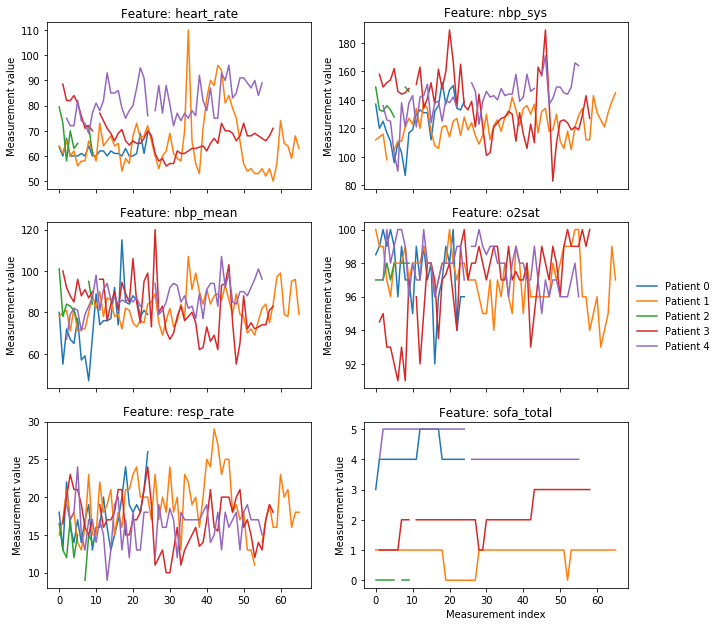

In [16]:
FEATURES_TO_PLOT = [
    "heart_rate",
    "nbp_sys",
    "nbp_mean",
    "o2sat",
    "resp_rate",
    "sofa_total",
]


def plot_features(
    n_ids_to_plot=5, n_features_to_plot=(3, 2), figsize=(8 * 1.3, 8 * 1.3)
):
    np.random.seed(1)
    ids_to_plot = np.random.choice(
        df["icustay_id"].unique(), size=n_ids_to_plot, replace=False
    )

    fig, axs = plt.subplots(
        n_features_to_plot[0], n_features_to_plot[1], sharex=True, figsize=figsize
    )
    for ax, feat in zip(axs.flatten(), FEATURES_TO_PLOT):
        for i, patient_id in enumerate(ids_to_plot):
            ax.set_title("Feature: {}".format(feat))
            df[df["icustay_id"].isin([patient_id])][feat].reset_index(drop=True).plot(
                ax=ax, label="Patient {}".format(i)
            )
        ax.set_ylabel("Measurement value")

    plt.xlabel("Measurement index")
    plt.legend(
        loc="lower left",
        bbox_to_anchor=(1.02, 1.4),
        ncol=1,
        borderaxespad=0,
        frameon=False,
    )


plot_features()

## Train Model
As our classifier, we train a gradient boosted tree, using [LightGBM](https://lightgbm.readthedocs.io/en/latest/). For illustrative purposes, we train using a fixed set of hyperparameters. These hyperparameters are based on optimising with respect to the training data, using 5-fold cross validation.

We train models across combinations of the SOFA window size $(x, y)$, sepsis onset time definitions and the prediction horizon $T$. In addition, we train separate models for the real-time and patient-level prediction tasks.

In [15]:
train_LGBM.train_LGBM(
    constants.T_list,
    constants.xy_pairs[1:3],
    constants.FEATURES,
    constants.exclusion_rules[0],
)

Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/results/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/data/processed/blood_only/train/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/results/blood_only/LGBM/  already exists
24 12 12 t_sofa
Model fitting:
0.85006993006993


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 12 t_suspicion
Model fitting:
0.8500454752160073


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 12 t_sepsis_min
Model fitting:
0.850061804697157


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 8 t_sofa
Model fitting:
0.8500981637602495


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 8 t_suspicion
Model fitting:
0.8500638026371756


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 8 t_sepsis_min
Model fitting:
0.8500392156862745


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 6 t_sofa
Model fitting:
0.8500341763499658


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 6 t_suspicion
Model fitting:
0.850068422853233


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 6 t_sepsis_min
Model fitting:
0.8501118568232662


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 4 t_sofa
Model fitting:
0.8500448430493274


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 4 t_suspicion
Model fitting:
0.8500173591019557


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
24 12 4 t_sepsis_min
Model fitting:
0.8501228501228502


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 12 t_sofa
Model fitting:
0.85


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 12 t_suspicion
Model fitting:
0.8500339904826648


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 12 t_sepsis_min
Model fitting:
0.8500429500552215


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 8 t_sofa
Model fitting:
0.8500477554918816


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 8 t_suspicion
Model fitting:
0.8500123752165663


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 8 t_sepsis_min
Model fitting:
0.8500077555452148


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 6 t_sofa
Model fitting:
0.8500647668393783


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 6 t_suspicion
Model fitting:
0.8500246184145741


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 6 t_sepsis_min
Model fitting:
0.8500092131932928


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 4 t_sofa
Model fitting:
0.85


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 4 t_suspicion
Model fitting:
0.8500860813137333


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists
12 6 4 t_sepsis_min
Model fitting:
0.8501216545012166
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train/  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


## Evaluate Model
For each prediction task and for each combination of SOFA window size, sepsis onset time definition and prediction horizon, we evaluate the model's performance using receiver operating characteristic area under the curve (ROCAUC). For illustrative purposes, we compute in-sample performance.

In [17]:
eval_lgbm.eval_LGBM(
    constants.T_list,
    constants.xy_pairs[1:3],
    constants.FEATURES,
    constants.exclusion_rules[0],
    train_test="train",
    fake_test=False,
)

Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/  already exists
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/results/blood_only/LGBM/  already exists
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/data/processed/blood_only/train/
24 12 12 t_sofa
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_12_sofa.pkl
Model fitting:
auc,sepcificity,sensitivity 0.8499751988750701 0.6650657200199538 0.85006993006993
accuracy 0.670646740980139
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 12 t_suspicion
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_12_suspicion.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9287377052563499 0.8390555662328498 0.8500454752160073
accuracy 0.8395835096927114
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 12 t_sepsis_min
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_12_sepsis_min.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9352466618858162 0.8597139344333768 0.850061804697157
accuracy 0.8594921862797718
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 8 t_sofa
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_8_sofa.pkl
Model fitting:
auc,sepcificity,sensitivity 0.8584451093732611 0.676162277793474 0.8500981637602495
accuracy 0.6803986262414878
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 8 t_suspicion
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_8_suspicion.pkl
Model fitting:
auc,sepcificity,sensitivity 0.924721731866855 0.8336878757842299 0.8500638026371756
accuracy 0.834318670245738
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 8 t_sepsis_min
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_8_sepsis_min.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9057155207407203 0.7854159797779976 0.8500392156862745
accuracy 0.7865859026458453
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 6 t_sofa
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_6_sofa.pkl
Model fitting:
auc,sepcificity,sensitivity 0.8636103857393612 0.6867256738827017 0.8500341763499658
accuracy 0.6900858177154092
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 6 t_suspicion
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_6_suspicion.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9191861942719703 0.8260195029209249 0.850068422853233
accuracy 0.826787328339746
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 6 t_sepsis_min
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_6_sepsis_min.pkl
Model fitting:
auc,sepcificity,sensitivity 0.8964516835314279 0.76007070908058 0.8501118568232662
accuracy 0.7614422795673275
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 4 t_sofa
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_4_sofa.pkl
Model fitting:
auc,sepcificity,sensitivity 0.86608994100025 0.6896721208415013 0.8500448430493274
accuracy 0.6921869594201187
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 4 t_suspicion
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_4_suspicion.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9043130758156993 0.7883779596265822 0.8500173591019557
accuracy 0.7898324153543254
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


24 12 4 t_sepsis_min
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/24_12_4_sepsis_min.pkl
Model fitting:
auc,sepcificity,sensitivity 0.88379120984424 0.7316694774281963 0.8501228501228502
accuracy 0.733038561696158
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 12 t_sofa
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_12_sofa.pkl
Model fitting:
auc,sepcificity,sensitivity 0.858482382387737 0.6836980651756677 0.85
accuracy 0.6874292740517212
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 12 t_suspicion
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_12_suspicion.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9377764562523236 0.8670945003157582 0.8500339904826648
accuracy 0.8664902620307079
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 12 t_sepsis_min
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_12_sepsis_min.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9363530464873034 0.8571141998139423 0.8500429500552215
accuracy 0.8569726010566409
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 8 t_sofa
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_8_sofa.pkl
Model fitting:
auc,sepcificity,sensitivity 0.8671818273812029 0.6990150572284424 0.8500477554918816
accuracy 0.7017263254838757
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 8 t_suspicion
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_8_suspicion.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9363195990204106 0.8654950745513527 0.8500123752165663
accuracy 0.865043230371774
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 8 t_sepsis_min
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_8_sepsis_min.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9281940984649989 0.8371647653076256 0.8500077555452148
accuracy 0.8373682270549208
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 6 t_sepsis_min
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_6_sepsis_min.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9117952880312027 0.7942907380150078 0.8500092131932928
accuracy 0.7950337879346357
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 4 t_sofa
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_4_sofa.pkl
Model fitting:
auc,sepcificity,sensitivity 0.8785864093415711 0.7215374932476968 0.85
accuracy 0.7230163667804813
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 4 t_suspicion
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_4_suspicion.pkl
Model fitting:
auc,sepcificity,sensitivity 0.9197993299918358 0.8300317326414604 0.8500860813137333
accuracy 0.8303963325813263
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


12 6 4 t_sepsis_min
Trained model from dic: /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/models/blood_only/LGBM/12_6_4_sepsis_min.pkl
Model fitting:
auc,sepcificity,sensitivity 0.8876975490441225 0.7276263528944494 0.8501216545012166
accuracy 0.7288634967440718
Directory  /scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/outputs/predictions/blood_only/LGBM/train  already exists


/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:449: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:447: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)
/scratch/fosterp/Mimiciii_Sepsis_Label_Extraction/src/visualization/patientlevel_function.py:455: RuntimeWarning: invalid value encountered in long_scalars
  FDR = FP / (TP + FP)


In [18]:
result_df = pd.read_csv(
    str(
        Path(
            MIMIC_ANALYSIS_PATH,
            "outputs/predictions/blood_only/LGBM/train/train_results.csv",
        ).resolve()
    )
)

results_patient_level_df = pd.read_csv(
    str(
        Path(
            MIMIC_ANALYSIS_PATH,
            "outputs/results/blood_only/LGBM/train_patient_level_results.csv",
        ).resolve()
    )
)

## Plot Results
Plot results across combinations of SOFA window size, sepsis onset time definition and prediction horizon, for the real-time and patient-level prediction tasks:

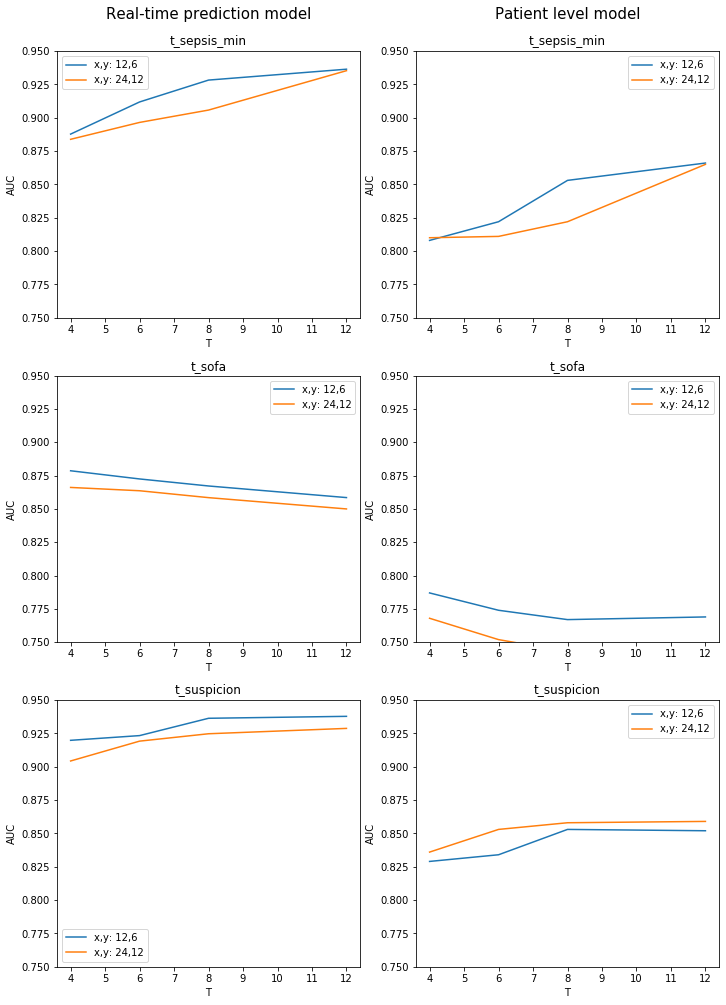

In [19]:
def plot_results(
    dfs=(result_df, results_patient_level_df),
    titles=("Real-time prediction model", "Patient level model"),
    auc_range=(0.75, 0.95),
    figsize=(11, 14),
):
    n_definitions = len(result_df["definition"].unique())
    n_dfs = len(dfs)

    fig, axs = plt.subplots(n_definitions, n_dfs, figsize=figsize)

    def plot_df(df, axs):
        for (group_name, df), ax in zip(df.groupby("definition"), axs):
            df.set_index("T", inplace=True)
            df.groupby("x,y")["auc"].plot(ax=ax, legend=True)

            ax.set_ylim(auc_range)
            ax.set_ylabel("AUC")
            ax.set_title(group_name)
            for text in ax.legend().get_texts():
                text.set_text("x,y: {}".format(text.get_text()))

    for df, axs, title in zip(dfs, axs.T, titles):
        axs[0].annotate(
            title,
            xy=(0.5, 1.12),
            xytext=(0, 0),
            xycoords="axes fraction",
            textcoords="offset points",
            size=15,
            ha="center",
            va="baseline",
        )
        plot_df(df, axs)

    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95)
    plt.show()


plot_results()